In [1]:
! pip install catboost


In [2]:
! pip install category_encoders

     ---------------------------------------- 72.4/72.4 kB 1.3 MB/s eta 0:00:00


In [3]:
! pip install xgboost

In [4]:
import optuna

In [5]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


import tqdm
import joblib

import shap

pd.set_option('display.max_columns', 70)
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False
style.use('ggplot')
sns.set_palette('Set2')

import warnings
warnings.filterwarnings('ignore')

In [6]:
train = pd.read_csv('D:/TMLC/Energy Intensity Prediction/Dataset/train.csv')
test = pd.read_csv('D:/TMLC/Energy Intensity Prediction/Dataset/test.csv')

In [7]:
df_train = train.copy()
df_test = test.copy()

In [8]:
print(df_train.shape)
print(df_test.shape)

(75757, 64)
(9705, 63)


In [9]:
train

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75752,6,State_11,Commercial,Office_Uncategorized,20410.0,1995.0,8.0,36.6,28,43.451613,56,34,47.672414,64,35,49.354839,71,40,56.266667,89,45,59.193548,88,47,63.566667,91,54,66.951613,87,52,68.612903,91,44,61.383333,79,39,55.403226,68,40,51.283333,71,24,38.532258,51,260,3772,45.03,1.4,1,55.147541,6,0,0,0,25,3,0,0,NaN,NaN,NaN,NaN,132.918411,75752
75753,6,State_11,Residential,5plus_Unit_Building,40489.0,1910.0,98.0,36.6,28,43.451613,56,34,47.672414,64,35,49.354839,71,40,56.266667,89,45,59.193548,88,47,63.566667,91,54,66.951613,87,52,68.612903,91,44,61.383333,79,39,55.403226,68,40,51.283333,71,24,38.532258,51,260,3772,45.03,1.4,1,55.147541,6,0,0,0,25,3,0,0,NaN,NaN,NaN,NaN,39.483672,75753
75754,6,State_11,Commercial,Commercial_Other,28072.0,1917.0,NaN,36.6,26,36.612903,48,30,41.637931,58,29,41.338710,62,34,50.183333,79,40,52.145161,79,41,56.233333,86,48,58.758065,81,48,61.612903,87,41,53.783333,73,37,47.661290,59,34,44.650000,62,15,30.338710,46,55,6218,106.32,36.6,438,47.911202,26,2,0,0,6,0,0,0,NaN,NaN

In [10]:
test

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id
0,7,State_1,Commercial,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75757
1,7,State_1,Commercial,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75758
2,7,State_1,Commercial,Grocery_store_or_food_market,16138.0,1950.0,1.0,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75759
3,7,State_1,Commercial,Grocery_store_or_food_market,97422.0,1971.0,34.0,35.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75760
4,7,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,35.0,1.8,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,340.0,330.0,22.8,126.0,75761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9700,7,State_11,Residential,5plus_Unit_Building,305925.0,2013.0,99.0,812.0,21,38.661290,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN,NaN,NaN,NaN,85457
9701,7,State_11,Residential,5plus_Unit_Building,34909.0,1910.0,94.0,26.5,21,38.661290,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN,NaN,NaN,NaN,85458
9702,7,State_11,Residential,5plus_Unit_Building,42393.0,2014.0,94.0,812.0,21,38.661290,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN,NaN,NaN,NaN,85459
9703,7,State_11,Residential,5pl

# EXPLORATORY DATA ANALYSIS

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [12]:
print(df_train.duplicated().sum())
print(df_test.duplicated().sum())

0
0


In [13]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9705 entries, 0 to 9704
Data columns (total 63 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                9705 non-null   int64  
 1   State_Factor               9705 non-null   object 
 2   building_class             9705 non-null   object 
 3   facility_type              9705 non-null   object 
 4   floor_area                 9705 non-null   float64
 5   year_built                 9613 non-null   float64
 6   energy_star_rating         7451 non-null   float64
 7   ELEVATION                  9705 non-null   float64
 8   january_min_temp           9705 non-null   int64  
 9   january_avg_temp           9705 non-null   float64
 10  january_max_temp           9705 non-null   int64  
 11  february_min_temp          9705 non-null   int64  
 12  february_avg_temp          9705 non-null   float64
 13  february_max_temp          9705 non-null   int64

In [14]:
test['site_eui'] = np.nan
test['dataset'] = 'test'
train['dataset'] = 'train'


df_all= pd.concat([train, test], axis=0, ignore_index=True)

In [15]:
df_all.head(20)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,dataset
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0,train
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1,train
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2,train
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3,train
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4,train
5,1,State_1,Commercial,Warehouse_Selfstorage,119900.0,1956.0,NaN,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,6.597715,5,train
6,1,State_1,Commercial,Warehouse_Nonrefrigerated,91367.0,1982.0,56.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,12.817841,6,train
7,1,State_1,Commercial,Warehouse_Nonrefrigerated,50422.0,1947.0,99.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,22.392014,7,train
8,1,State_1,Commercial,Office_Uncategorized,122020.0,1929.0,98.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,28.199578,8,train
9,1,State_1,Commercial,Office_Uncategorized,102612.0,1979.0,83.0,2.4,36,50.5,68

In [16]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85462 entries, 0 to 85461
Data columns (total 65 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                85462 non-null  int64  
 1   State_Factor               85462 non-null  object 
 2   building_class             85462 non-null  object 
 3   facility_type              85462 non-null  object 
 4   floor_area                 85462 non-null  float64
 5   year_built                 83533 non-null  float64
 6   energy_star_rating         56499 non-null  float64
 7   ELEVATION                  85462 non-null  float64
 8   january_min_temp           85462 non-null  int64  
 9   january_avg_temp           85462 non-null  float64
 10  january_max_temp           85462 non-null  int64  
 11  february_min_temp          85462 non-null  int64  
 12  february_avg_temp          85462 non-null  float64
 13  february_max_temp          85462 non-null  int

In [18]:
df_all.shape

(85462, 65)

In [19]:
#checking missing values
df_all.isnull().any().sum()

7

In [20]:
df_all.isnull().sum().sort_values(ascending = True)

Year_Factor                      0
id                               0
september_avg_temp               0
september_max_temp               0
october_min_temp                 0
                             ...  
energy_star_rating           28963
direction_max_wind_speed     49657
max_wind_speed               49657
direction_peak_wind_speed    50386
days_with_fog                54913
Length: 65, dtype: int64

In [21]:
# statistical measures about the data
df_all.describe()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
count,85462.000000,8.546200e+04,83533.000000,56499.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,85462.000000,35805.000000,35076.000000,35805.000000,30549.000000,75757.000000,85462.00000
mean,4.666671,1.656694e+05,1953.562616,61.531850,58.325913,11.669502,34.579333,59.163230,12.854403,36.220463,59.446386,21.781178,44.367040,70.927675,32.341368,53.832990,82.177471,44.026398,63.223390,88.802895,50.548080,70.668283,91.687206,59.718787,76.010540,94.845405,57.792481,74.792403,92.342351,50.246355,69.296622,92.277176,37.980272,58.574598,81.056715,28.236713,47.742669,70.747420,21.759098,40.994180,64.014778,1149.003815,4352.239393,42.334834,26.796569,148.102607,55.953474,49.381035,17.788151,4.941611,0.927441,80.905385,13.818247,0.271828,0.002165,74.606452,70.750627,4.630568,109.943010,82.584693,42730.50000
std,1.617635,2.486965e+05,37.667384,28.595425,118.276994,9.801683,7.033171,5.425332,12.692836,8.770221,8.637622,10.203711,6.626006,7.891359,5.621520,2.743682,5.146350,4.824492,3.140805,3.128770,3.793968,3.348447,3.536682,4.697073,4.562347,4.701093,4.889532,4.052279,3.997366,4.654465,3.582749,4.939723,5.085971,2.886783,5.695998,7.401171,4.522633,4.791307,10.497901,6.412649,6.053359,425.742868,873.196021,10.253751,18.265343,171.896487,2.491786,29.672478,15.732629,7.029200,2.828053,26.471258,11.226827,2.130802,0.133828,136.597569,135.612018,6.816503,51.186182,58.255403,24670.89869
min,1.000000,9.430000e+02,0.000000,0.000000,-6.400000,-19.000000,10.806452,42.000000,-13.000000,13.250000,38.000000,-9.000000,25.854839,53.000000,15.000000,40.280000,61.000000,23.000000,46.950000,64.000000,30.000000,54.100000,67.000000,37.000000,54.822581,65.000000,31.000000,56.693548,66.000000,26.000000,53.600000,64.000000,18.000000,44.693548,59.000000,4.000000,30.766667,53.000000,-16.000000,23.790323,42.000000,0.000000,398.000000,0.000000,0.000000,0.000000,44.512329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,12.000000,1.001169,0.00000
25%,3.000000,6.115500e+04,1927.000000,41.000000,11.900000,6.000000,29.827586,56.000000,2.000000,31.625000,56.000000,12.000000,38.096774,62.000000,28.000000,52.333333,80.000000,42.000000,61.750000,88.000000,49.000000,70.433333,89.000000,55.000000,74.516129,91.000000,54.000000,71.806452,90.000000,47.000000,67.866667,91.000000,35.000000,57.500000,78.000000,22.000000,44.733333,69.000000,17.000000,38.338710,60.000000,986.000000,3978.00

In [23]:
# checking the distribution of Target Varibale
df_all['site_eui'].value_counts()

79.781421    36
65.819672    36
69.210383    35
75.094262    35
88.557377    33
             ..
10.396353     1
75.600517     1
66.252720     1
65.090565     1
29.154684     1
Name: site_eui, Length: 61080, dtype: int64

In [25]:
object_columns = df_all.select_dtypes(include=['object']).columns

In [26]:
object_columns

Index(['State_Factor', 'building_class', 'facility_type', 'dataset'], dtype='object')

In [28]:
cols = df_all.select_dtypes([np.number]).columns
cols

Index(['Year_Factor', 'floor_area', 'year_built', 'energy_star_rating',
       'ELEVATION', 'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inches',
       'snowdepth_inches', 'avg_temp', 'days_below_3

<AxesSubplot:xlabel='site_eui', ylabel='Density'>

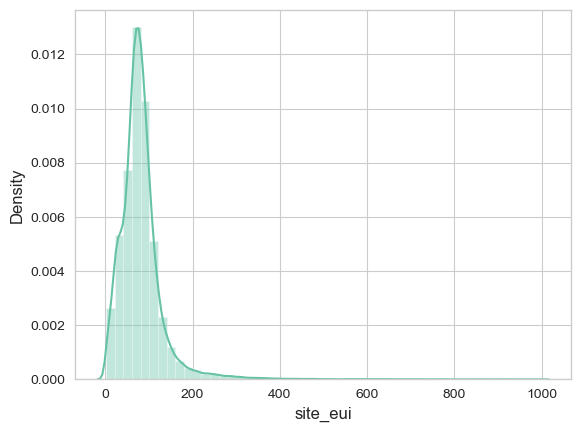

In [29]:
### Checking Outliers
sns.distplot(df_all['site_eui']) 

### Filling missing values 
### Catgorical variables with mode and Numerical variables with mean

In [30]:
df_all[cols] = df_all[cols].fillna(df_all[cols].mean())
df_all[cols]

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,61242.0,1942.0,11.0,2.4,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.000000,1.000000,1.000000,109.94301,248.682615,0
1,1,274000.0,1955.0,45.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.000000,70.750627,1.000000,12.00000,26.500150,1
2,1,280025.0,1951.0,97.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.000000,70.750627,1.000000,12.00000,24.693619,2
3,1,55325.0,1980.0,46.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.000000,70.750627,1.000000,12.00000,48.406926,3
4,1,66000.0,1985.0,100.0,2.4,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.000000,1.000000,1.000000,109.94301,3.899395,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85457,7,305925.0,2013.0,99.0,812.0,21,38.66129,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,74.606452,70.750627,4.630568,109.94301,82.584693,85457
85458,7,34909.0,1910.0,94.0,26.5,21,38.66129,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,74.606452,70.750627,4.630568,109.94301,82.584693,85458
85459,7,42393.0,2014.0,94.0,812.0,21,38.66129,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,74.606452,70.750627,4.630568,109.94301,82.584693,85459
85460,7,25368.0,1992.0,79.0,812.0,21,38.66129,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.53

In [31]:
object_columns = ['State_Factor', 'building_class', 'facility_type', 'dataset']
for i in object_columns:
    df_all[i].fillna(df_all[i].mode()[0], inplace=True)
    print(i)

State_Factor
building_class
facility_type
dataset


In [32]:
df_all.isnull().sum()

Year_Factor       0
State_Factor      0
building_class    0
facility_type     0
floor_area        0
                 ..
max_wind_speed    0
days_with_fog     0
site_eui          0
id                0
dataset           0
Length: 65, dtype: int64

In [33]:
df_all.isnull().any().sum()

0

### Encoding Concept 

In [35]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
object_columns = ['State_Factor', 'building_class', 'facility_type', 'dataset']

# Encode labels of multiple columns at once

df_all[object_columns] = df_all[object_columns].apply(le.fit_transform)

df_all.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,dataset
0,1,0,0,13,61242.0,1942.0,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.000000,1.0,109.94301,248.682615,0,1
1,1,0,0,55,274000.0,1955.0,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,70.750627,1.0,12.00000,26.500150,1,1
2,1,0,0,48,280025.0,1951.0,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,70.750627,1.0,12.00000,24.693619,2,1
3,1,0,0,6,55325.0,1980.0,46.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,70.750627,1.0,12.00000,48.406926,3,1
4,1,0,0,56,66000.0,1985.0,100.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.000000,1.0,109.94301,3.899395,4,1


In [36]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85462 entries, 0 to 85461
Data columns (total 65 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                85462 non-null  int64  
 1   State_Factor               85462 non-null  int64  
 2   building_class             85462 non-null  int64  
 3   facility_type              85462 non-null  int64  
 4   floor_area                 85462 non-null  float64
 5   year_built                 85462 non-null  float64
 6   energy_star_rating         85462 non-null  float64
 7   ELEVATION                  85462 non-null  float64
 8   january_min_temp           85462 non-null  int64  
 9   january_avg_temp           85462 non-null  float64
 10  january_max_temp           85462 non-null  int64  
 11  february_min_temp          85462 non-null  int64  
 12  february_avg_temp          85462 non-null  float64
 13  february_max_temp          85462 non-null  int

### Building a Model

In [37]:
df_all.tail(30)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,dataset
85432,7,2,1,1,103554.0,2000.0,97.00000,18.3,21,38.66129,54,28,41.625,59,33,46.5,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,74.606452,70.750627,4.630568,109.94301,82.584693,85432,0
85433,7,2,1,1,201656.0,1909.0,83.00000,26.5,21,38.66129,54,28,41.625,59,33,46.5,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,74.606452,70.750627,4.630568,109.94301,82.584693,85433,0
85434,7,2,1,1,305537.0,2014.0,91.00000,812.0,21,38.66129,54,28,41.625,59,33,46.5,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,74.606452,70.750627,4.630568,109.94301,82.584693,85434,0
85435,7,2,1,1,70850.0,1901.0,61.53185,26.5,21,38.66129,54,28,41.625,59,33,46.5,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,74.606452,70.750627,4.630568,109.94301,82.584693,85435,0
85436,7,2,1,1,209583.0,2014.0,100.00000,812.0,21,38.66129,54,28,41.625,59,33,46.5,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,74.606452,70.750627,4.630568,109.94301,82.584693,85436,0
85437,7,2,1,1,41510.0,1975.0,78.00000,33.5,21,38.66129,54,28,41.625,59,33,46.5,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,74.606452,70.750627,4.630568,109.94301,82.584693,85437,0
85438,7,2,1,1,36600.0,2008.0,98.00000,812.0,21,38.66129,54,28,41.625,59,33,46.5,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,74.606452,70.750627,4.630568,109.94301,82.584693,85438,0
85439,7,2,1,1,32870.0,1998.0,84.00000,26.5,21,38.66129,54,28,41.625,59,33,46.5,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,74.606452,70.750627,4.630568,109.94301,82.584693,85439,0
85440,7,2,1,1,68669.0,1988.0,82.00000,26.5,21,38.66129,54,28,41.625,59,33,46.5,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,74.606452,70.750627,4.630568,109.94301,8

In [38]:
train = df_all[df_all['dataset']==1]
test = df_all[df_all['dataset']==0]

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

test_ids = test['id']
train_ids = train['id']

target = train['site_eui']

train = train.drop(['id', 'dataset', 'site_eui'], axis=1)
test = test.drop(['id', 'dataset', 'site_eui'], axis=1)

In [39]:
train.head(20)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog
0,1,0,0,13,61242.0,1942.000000,11.00000,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.000000,1.0,109.94301
1,1,0,0,55,274000.0,1955.000000,45.00000,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,70.750627,1.0,12.00000
2,1,0,0,48,280025.0,1951.000000,97.00000,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,70.750627,1.0,12.00000
3,1,0,0,6,55325.0,1980.000000,46.00000,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,70.750627,1.0,12.00000
4,1,0,0,56,66000.0,1985.000000,100.00000,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.000000,1.0,109.94301
5,1,0,0,58,119900.0,1956.000000,61.53185,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.000000,1.0,109.94301
6,1,0,0,56,91367.0,1982.000000,56.00000,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.000000,1.0,109.94301
7,1,0,0,56,50422.0,1947.000000,99.00000,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.000000,1.0,109.94301
8,1,0,0,32,122020.0,1929.000000,98.00000,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.000000,1.0,109.94301
9,1,0,0,32,102612.0,1979.000000,83.00000,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.000000,1.0,109.94301


In [40]:
test

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog
0,7,0,0,13,28484.0,1994.0,37.0,2.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,74.606452,70.750627,4.630568,109.94301
1,7,0,0,13,21906.0,1961.0,55.0,45.7,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,74.606452,70.750627,4.630568,109.94301
2,7,0,0,13,16138.0,1950.0,1.0,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,74.606452,70.750627,4.630568,109.94301
3,7,0,0,13,97422.0,1971.0,34.0,35.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,74.606452,70.750627,4.630568,109.94301
4,7,0,0,13,61242.0,1942.0,35.0,1.8,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,340.000000,330.000000,22.800000,126.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9700,7,2,1,1,305925.0,2013.0,99.0,812.0,21,38.661290,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,74.606452,70.750627,4.630568,109.94301
9701,7,2,1,1,34909.0,1910.0,94.0,26.5,21,38.661290,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,74.606452,70.750627,4.630568,109.94301
9702,7,2,1,1,42393.0,2014.0,94.0,812.0,21,38.661290,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,74.606452,70.750627,4.630568,109.94301
9703,7,2,1,1,25368.0,1992.0,79.0,812.0,21,38.661290,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,2

In [41]:
train

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog
0,1,0,0,13,61242.0,1942.0,11.00000,2.4,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.000000,1.000000,1.000000,109.94301
1,1,0,0,55,274000.0,1955.0,45.00000,1.8,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.000000,70.750627,1.000000,12.00000
2,1,0,0,48,280025.0,1951.0,97.00000,1.8,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.000000,70.750627,1.000000,12.00000
3,1,0,0,6,55325.0,1980.0,46.00000,1.8,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.000000,70.750627,1.000000,12.00000
4,1,0,0,56,66000.0,1985.0,100.00000,2.4,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.000000,1.000000,1.000000,109.94301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75752,6,2,0,32,20410.0,1995.0,8.00000,36.6,28,43.451613,56,34,47.672414,64,35,49.354839,71,40,56.266667,89,45,59.193548,88,47,63.566667,91,54,66.951613,87,52,68.612903,91,44,61.383333,79,39,55.403226,68,40,51.283333,71,24,38.532258,51,260,3772,45.03,1.4,1,55.147541,6,0,0,0,25,3,0,0,74.606452,70.750627,4.630568,109.94301
75753,6,2,1,1,40489.0,1910.0,98.00000,36.6,28,43.451613,56,34,47.672414,64,35,49.354839,71,40,56.266667,89,45,59.193548,88,47,63.566667,91,54,66.951613,87,52,68.612903,91,44,61.383333,79,39,55.403226,68,40,51.283333,71,24,38.532258,51,260,3772,45.03,1.4,1,55.147541,6,0,0,0,25,3,0,0,74.606452,70.750627,4.630568,109.94301
75754,6,2,0,2,28072.0,1917.0,61.53185,36.6,26,36.612903,48,30,41.637931,58,29,41.338710,62,34,50.183333,79,40,52.145161,79,41,56.233333,86,48,58.758065,81,48,61.612903,87,41,53.783333,73,37,47.661290,59,34,44.650000,62,15,30.338710,46,55,6218,106.32,36.6,438,47.911202,26,2,0,0,6,0,0,0,74.606452,70.750627,4.630568,109.94301
75755,6,2,0,2,53575.0,2012.0,61.53185,36.6,26,36.612903,48,30,41.637931,58,29,41.338710,62,34,50.183333,79,40,52.145161,79,41,56.233333,86,48,58.758065,81,48,61.612903,87,41,53.783333,73,37,47.661290,59,34

In [42]:
y_test = pd.read_csv('D:/TMLC/Energy Intensity Prediction/Dataset/Y_test.csv')

X_train = train
X_test = test
y_train = target
y_test = y_test['site_eui']
print('Train: ', X_train.shape)
print('Test:', X_test.shape)
print('Samples: ', y_train.shape)
print('Targets: ', y_test.shape)

Train:  (75757, 62)
Test: (9705, 62)
Samples:  (75757,)
Targets:  (9705,)


In [43]:
y_test

0       166.588554
1       259.381565
2       158.537090
3       261.441520
4       242.967711
           ...    
9700     23.677329
9701     20.512284
9702     39.285975
9703     29.529438
9704     15.492899
Name: site_eui, Length: 9705, dtype: float64

### Feature selection

In [44]:
from sklearn.feature_selection import mutual_info_regression
# determine the mutual information
mutual_info = mutual_info_regression(X_train, y_train)
mutual_info

array([0.20057136, 0.15348904, 0.0403875 , 0.23818532, 0.10170714,
       0.0677306 , 0.24595926, 0.16430356, 0.24543117, 0.37957895,
       0.3123305 , 0.37309057, 0.3782162 , 0.33199376, 0.3449395 ,
       0.38021774, 0.34550293, 0.35780423, 0.37655307, 0.24054924,
       0.35370585, 0.26759236, 0.30176353, 0.32531439, 0.3785139 ,
       0.32315824, 0.20167562, 0.37455225, 0.14971255, 0.20667003,
       0.37810467, 0.33332039, 0.33800106, 0.37423647, 0.28755536,
       0.28473325, 0.36549753, 0.32676778, 0.36548184, 0.37996458,
       0.32671927, 0.33907132, 0.37842474, 0.36399339, 0.37693111,
       0.38010466, 0.37772956, 0.37512117, 0.37396404, 0.38216136,
       0.37855756, 0.24039878, 0.29969905, 0.27414744, 0.37717755,
       0.28838978, 0.01360306, 0.        , 0.02989219, 0.02954356,
       0.02857768, 0.11044373])

In [45]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

avg_temp                     0.382161
march_avg_temp               0.380218
heating_degree_days          0.380105
november_avg_temp            0.379965
january_avg_temp             0.379579
                               ...   
direction_max_wind_speed     0.029892
direction_peak_wind_speed    0.029544
max_wind_speed               0.028578
days_above_100F              0.013603
days_above_110F              0.000000
Length: 62, dtype: float64

<AxesSubplot:>

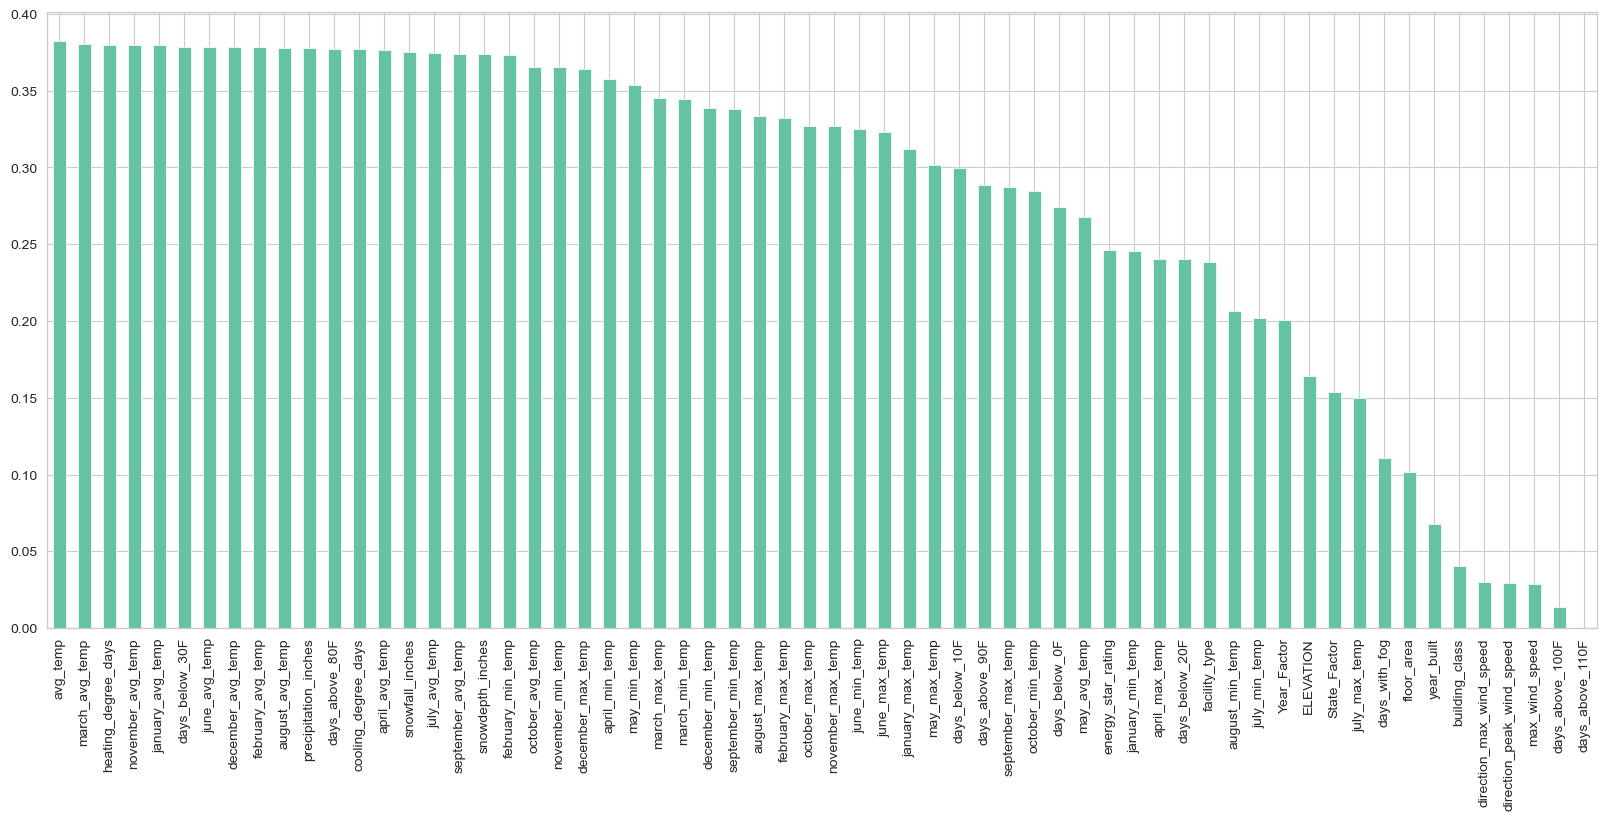

In [46]:
#let's plot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [47]:
from sklearn.feature_selection import SelectKBest

In [49]:
#No we Will select the  top 5 important features
sel_five_cols = SelectKBest(mutual_info_regression, k=5)
sel_five_cols.fit(X_train, y_train)
X_train.columns[sel_five_cols.get_support()]

Index(['january_avg_temp', 'november_avg_temp', 'december_avg_temp',
       'heating_degree_days', 'avg_temp'],
      dtype='object')

In [50]:
X_train.shape

(75757, 62)

In [51]:
X_train_new = sel_five_cols.transform(X_train)
X_test_new =  sel_five_cols.transform(X_test)

In [52]:
X_train_new.shape

(75757, 5)

In [53]:
xgb = XGBRegressor(n_estimators=500, reg_alpha=0.01, n_jobs=-1)
xgb.fit(X_train_new, y_train)
y_pred = xgb.predict(X_test_new)

In [54]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 64.25991365283973
 MAE: 40.45224115327223
 MSE: 4129.336502670417
 R2: -0.14206438183271186


In [55]:
rf = RandomForestRegressor(random_state=1, criterion='mse', max_depth = 15, min_samples_split= 2)
rf.fit(X_train_new, y_train)
y_pred = rf.predict(X_test_new)

In [56]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 62.22484037269603
 MAE: 38.64830730397032
 MSE: 3871.930759407502
 R2: -0.0708728161006289


In [57]:
model =  RandomForestRegressor()

In [58]:
model.fit(X_train_new, y_train)

RandomForestRegressor()

In [59]:
y_pred =model.predict(X_test_new)

In [60]:
y_pred

array([33.71686518, 33.71686518, 33.71686518, ..., 85.98683656,
       85.98683656, 85.98683656])

### Final Evaluation (Random Forest)

Text(0.5, 0, 'iteration')

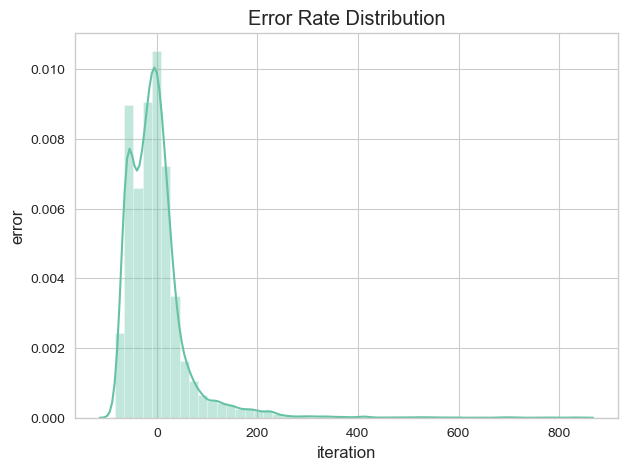

In [61]:
y_hat_tuned = model.predict(X_test_new)

plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

### Saving Models

In [62]:
import pickle 
pickle_out = open("model.pkl", mode = "wb") 
pickle.dump(model, pickle_out) 
pickle_out.close()